References:\
    https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/ (pickle)\
    https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de(custom Imputer)

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import xgboost

import random
random.seed(42)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [5]:
from src.pandas_helper import *

**Note:** To speed up running of model fit cells, the n_jobs parameter is set to a global variable. This is defaulted to -1 to allow access to the entirety of your machine's CPU resources. This ***will*** make your machine essentially unusable until the operations have finished performing. Set this to None for regular operations

In [49]:
Notebook_n_jobs = 5

# Load Data

In [7]:
X = pd.read_csv('data/Training_set.csv')
y = pd.read_csv('data/Training_labels.csv').status_group

In [8]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,3,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
functional,32259,54.308081
non functional,22824,38.424242
functional needs repair,4317,7.267677


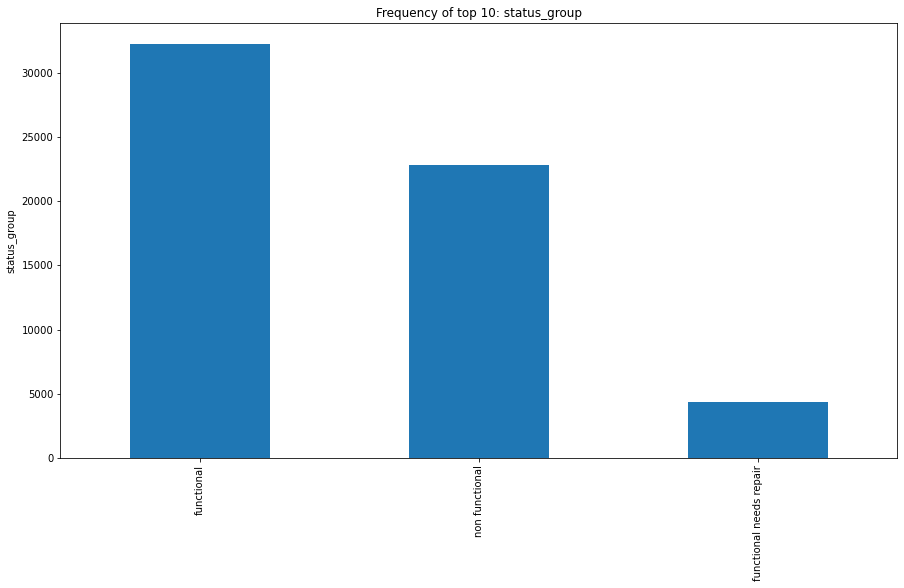

In [9]:
colInfo(y)

# Train Test Split

In [10]:
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [11]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [12]:
y_test.value_counts()

functional                 8098
non functional             5678
functional needs repair    1074
Name: status_group, dtype: int64

# Pipelines

### GPS coordinates

In [13]:
X_train[['latitude','longitude']].value_counts()[:3]

latitude       longitude
-2.000000e-08  0.000000     1339
-6.980216e+00  39.096499       2
-7.056372e+00  37.375717       2
dtype: int64

In [14]:
X_test[['latitude','longitude']].value_counts()[:3]

latitude       longitude
-2.000000e-08  0.000000     473
-2.490324e+00  32.987670      2
-6.963557e+00  37.543351      2
dtype: int64

The data set has 1812 (inluding the test set) records where the latitude and longitude were not correctly recorded. They've been recorded as $(-2\times10^{-8},0)$ or effectively $(0,0)$ which is off the west coast of Africa in the Atlantic Ocean. All of these coordinates belong to 2 regions. We will use a custom imputer to impute these values during our pipeline operations.

In [15]:
from src.sklearn_helper import CoordinatesImputer

### construction_year

,Number,Percentage
,,
Zeroes,"15,463",34.71 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,55,0.12 %
Mean,1303.75,-
Median,1986.00,-


,Value Count,% Value Count
0,15463,34.709315
2010,2001,4.491582
2008,1959,4.397306
2009,1892,4.246914
2000,1595,3.580247
2007,1195,2.682379
2006,1103,2.475870
2003,989,2.219978
2011,943,2.116723
2012,839,1.883277


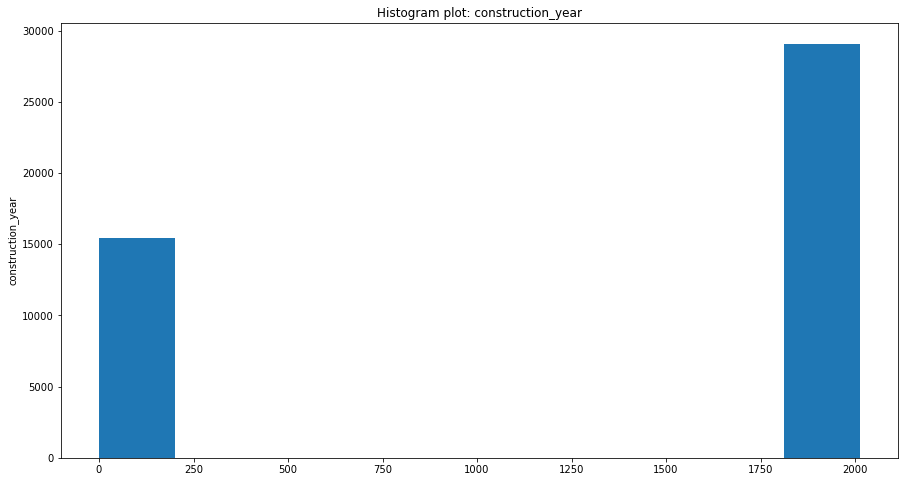

In [16]:
colInfo(X_train.construction_year)

Every well water pump has a construction year. However, as you can see in the training set there is a high number (34%) of zeroes. Assuming that this is an error and well water pumps were not being installed in 0AD, we shall impute these values using kNN imputer. Lets look at what the rest of the data looks like.

In [17]:
# enc_columnNames =  
# col_ImputeToMedian + \
# list(ct.transformers_[1][1]['cat1_ohe'].get_feature_names_out())  +\
# list(ct.transformers_[2][1]['cat2_ohe'].get_feature_names_out())

# X_train_proc = pd.DataFrame(ct.fit_transform(X_train,y_train),columns = enc_columnNames)
# X_test_proc = pd.DataFrame(ct.transform(X_test),columns = enc_columnNames)

# print(X_train_proc)
# print(X_test_proc)

### Transformations

In [18]:
#Impute nans as well as unknowns
subpipe_cat1 = Pipeline(steps=[
    ('cat1_imp1', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('cat1_imp2', SimpleImputer(missing_values='unknown',strategy='most_frequent')),
    ('cat1_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Only OneHotEncode
subpipe_cat2 = Pipeline(steps=[
    ('cat2_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Impute median and scale (0,1)
subpipe_num = Pipeline(steps=[
    ('num_imp', SimpleImputer(missing_values=np.nan,strategy='median')),
    ('num_sc', MinMaxScaler()),    
])

#kNN impute then scale (0,1)
subpipe_cYr = Pipeline(steps=[
    ('cYr_imp', KNNImputer(missing_values=0,n_neighbors=3)),
    ('cYr_sc', MinMaxScaler()),    
])






#Specifically designed for imputing erroneous coordinates
#As part of your column transformations,an additional column (default='region') will be needed to be passed
#Returning dataframe excludes this additional column
#Impute (0,0) coordinates from the corresponding regions mean/median  and scale (0,1)
subpipe_coord = Pipeline(steps=[
    ('coord_imp', CoordinatesImputer(groupByTarget='region',metric='median')), 
    ('coord_sc', MinMaxScaler()),    
])

In [19]:
def modelReport(model, X, y):

    # Using cross_val_predict to create a confusion matrix
    preds = cross_val_predict(estimator=model, X=X, y=y)
    cm = confusion_matrix(y, preds, labels=model.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap='OrRd', ax=ax)

    # Getting cross val scores
    getAllCrossValScores(model, X, y)


def getAllCrossValScores(model, X, y):
    # Using cross_validate to generate accuracy, recall, precision and f1-scores
    cv = cross_validate(model, X, y, scoring=[
                        'accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    acc = cv['test_accuracy'].mean()
    pr = cv['test_precision_macro'].mean()
    re = cv['test_recall_macro'].mean()
    f1 = cv['test_f1_macro'].mean()

    data = [
        ['Accuracy',  f'{acc:.4f}'],
        ['Precision', f'{pr:.4f}'],
        ['Recall', f'{re:.4f}'],
        ['F1', f'{f1:.4f}'],
    ]

    info_table = pd.DataFrame(data, columns=['', 'Scores']).set_index(
        '').style.set_caption("Cross Validation Results")
    display(info_table)


def prettyPrintGridCVResults(GSCVModel):
    list_cols = ['rank_test_accuracy']
    list_metrics = ['mean_test_accuracy', 'mean_test_precision_macro',
                      'mean_test_recall_macro', 'mean_test_f1_macro']
    list_cols.extend(list_metrics)

    for col in GSCVModel.cv_results_.keys():
        if col.startswith('param_'):
            list_cols.append(col)
    
    


    table = pd.DataFrame(GSCVModel.cv_results_)
    for m in list_metrics:
        table[m] = table[m].map('{:,.4f}'.format)
    table = table[list_cols].sort_values(by='rank_test_accuracy')
    

        
    table.rename(columns={'rank_test_accuracy': 'Rank (By Accuracy)',
                          'mean_test_accuracy': 'Mean Test Accuracy',
                          'mean_test_precision_macro': 'Mean Test Precision (macro)',
                          'mean_test_recall_macro': 'Mean Test Recall (macro)',
                          'mean_test_f1_macro': 'Mean Test F1-Score (macro)'
                          }, inplace=True)
    

    return table.set_index('Rank (By Accuracy)')

# Models - Baselines

## Model 00 - Dummy Classifier

Using a dummy classifier to establish our baseline.\
Since, this classifier doesn ignores input variables, and in the interest of time, we will not employ our column transformation pipeline.

In [18]:
baseline_00 = DummyClassifier()
baseline_00.fit(X_train,y_train)

array([0.54231201, 0.54242424, 0.54231201, 0.54231201, 0.54231201])

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saads\anaconda3\envs\learn-env\lib\site-

,Scores
,
Accuracy,0.5423
Precision,0.1808
Recall,0.3333
F1,0.2344


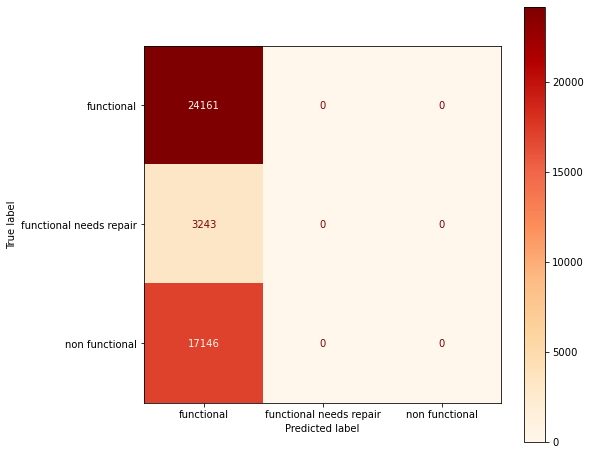

In [20]:
modelReport(baseline_00,X_train,y_train)

54% accuracy and 18% precision. Thats our dummy classifier baseline

In [21]:
filePath = f'models/{baseline_00=}'.split('=')[0] + '.sav'
pickle.dump(baseline_00, open(filePath, 'wb'))

##  Model 01 - Logistic Regression

### Simple Model

In [23]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

,Scores
,
Accuracy,0.7279
Precision,0.6146
Recall,0.5115
F1,0.5056


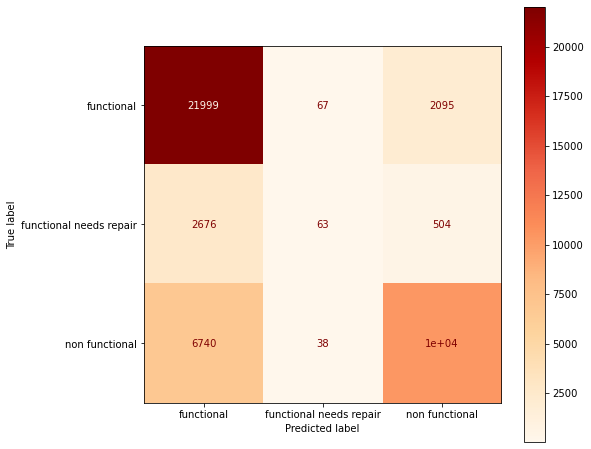

In [24]:
log_reg_pipe = Pipeline([
    ('ct', ct),
    ('log_reg', LogisticRegression(random_state=42, n_jobs=Notebook_n_jobs))
])
log_reg_pipe.fit(X_train, y_train)
modelReport(log_reg_pipe,X_train,y_train)

In [25]:
filePath = f'models/{log_reg_pipe=}'.split('=')[0] + '.sav'
pickle.dump(log_reg_pipe, open(filePath, 'wb'))

72.79% accuracy and 61.46% precision. \
In conjunction with our column transformer a simple logistic regression model shows massive improvements over the baseline.

Lets try and tune it better.

### Hypertuned Logistic Regression model

In [36]:
params = {}
params['log_reg__C'] = [0.1, 1, 10,100]
params['log_reg__max_iter'] = [50,100, 150,200]
params['log_reg__solver'] = ['lbfgs', 'sag']

log_reg_gs1 = GridSearchCV(estimator=log_reg_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)
log_reg_gs1.fit(X_train, y_train)

filePath = f'models/{log_reg_gs1=}'.split('=')[0] + '.sav'
pickle.dump(log_reg_gs1, open(filePath, 'wb'))

In [37]:
prettyPrintGridCVResults(log_reg_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_log_reg__C,param_log_reg__max_iter,param_log_reg__solver
Rank (By Accuracy),,,,,,,
1,0.7281,0.6077,0.5116,0.5056,10,100,lbfgs
2,0.7280,0.5880,0.5106,0.5034,100,100,lbfgs
3,0.7280,0.6137,0.5115,0.5054,1,150,lbfgs
4,0.7279,0.6137,0.5115,0.5054,1,200,lbfgs
5,0.7279,0.6137,0.5115,0.5054,1,200,sag
5,0.7279,0.6132,0.5116,0.5056,100,150,lbfgs
5,0.7279,0.6137,0.5115,0.5054,1,150,sag
5,0.7279,0.6146,0.5115,0.5056,1,100,lbfgs
9,0.7279,0.6132,0.5115,0.5054,10,200,lbfgs


We were able to bump up the accuracy by minor amount with an almost equal amount loss in precision

# Iterative Models

## Random Forest

### Simple Model

In [42]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

,Scores
,
Accuracy,0.7869
Precision,0.6885
Recall,0.6540
F1,0.6676


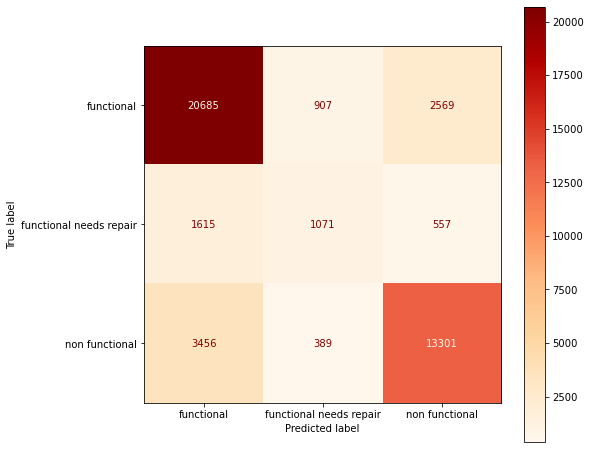

In [43]:
rfc_model_pipe = Pipeline([
    ('ct',ct),
   ('rfc',RandomForestClassifier(random_state=42,n_jobs=Notebook_n_jobs))
])

rfc_model_pipe.fit(X_train,y_train)
modelReport(rfc_model_pipe,X_train,y_train)

filePath = f'models/{rfc_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(rfc_model_pipe, open(filePath, 'wb'))

Our base Random Forest Classifier is best performer so far with an accuracy of 78.7% and an F1-score of 66.76%

### Hypertuned Random Forest

In [49]:
params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = [350,450,500]
params['rfc__max_depth'] = [20,23,27,30]
params['rfc__max_leaf_nodes']=[4000,4500,5000]


rfc_gs1 = GridSearchCV(estimator=rfc_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

rfc_gs1.fit(X_train,y_train)

filePath = f'models/{rfc_gs1=}'.split('=')[0] + '.sav'
pickle.dump(rfc_gs1, open(filePath, 'wb'))

In [50]:
prettyPrintGridCVResults(rfc_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_rfc__criterion,param_rfc__max_depth,param_rfc__max_leaf_nodes,param_rfc__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7977,0.7197,0.6444,0.6675,entropy,27,4500,450
2,0.7976,0.7195,0.6444,0.6675,entropy,30,4500,500
3,0.7976,0.7197,0.6444,0.6676,entropy,27,4500,500
4,0.7975,0.7217,0.6387,0.6626,entropy,27,4000,500
5,0.7974,0.7191,0.6441,0.6671,entropy,30,4500,350
...,...,...,...,...,...,...,...,...
68,0.7947,0.7249,0.6282,0.6529,gini,20,4500,450
69,0.7946,0.7247,0.6286,0.6532,gini,20,5000,500
70,0.7945,0.7245,0.6290,0.6537,gini,20,4500,350


We increased our accuracy marginally to 79.77% but significantly increased our F1-score to 66.75

### Hypertuned and SMOTE Random Forest

In [ ]:
rfc_imb_model_pipe = ImPipeline([
    ('ct',ct),
    ('sm',SMOTE(random_state=42)),
   ('rfc',RandomForestClassifier(random_state=42))
])

rfc_imb_model_pipe.fit(X_train,y_train)

In [ ]:
params = {}
params['rfc__criterion'] = ['entropy']
params['rfc__n_estimators'] = [450]
params['rfc__max_depth'] = [25,30]
params['rfc__max_leaf_nodes']=[4500]

rfc_imb_gs1 = GridSearchCV(estimator=rfc_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

rfc_imb_gs1.fit(X_train,y_train)

filePath = f'models/{rfc_imb_gs1=}'.split('=')[0] + '.sav'
pickle.dump(rfc_imb_gs1, open(filePath, 'wb'))

In [50]:
prettyPrintGridCVResults(rfc_imb_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_rfc__criterion,param_rfc__max_depth,param_rfc__max_leaf_nodes,param_rfc__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7977,0.7197,0.6444,0.6675,entropy,27,4500,450
2,0.7976,0.7195,0.6444,0.6675,entropy,30,4500,500
3,0.7976,0.7197,0.6444,0.6676,entropy,27,4500,500
4,0.7975,0.7217,0.6387,0.6626,entropy,27,4000,500
5,0.7974,0.7191,0.6441,0.6671,entropy,30,4500,350
...,...,...,...,...,...,...,...,...
68,0.7947,0.7249,0.6282,0.6529,gini,20,4500,450
69,0.7946,0.7247,0.6286,0.6532,gini,20,5000,500
70,0.7945,0.7245,0.6290,0.6537,gini,20,4500,350


## kNN

### Simple Model

In [42]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

,Scores
,
Accuracy,0.7731
Precision,0.6834
Recall,0.6309
F1,0.6491


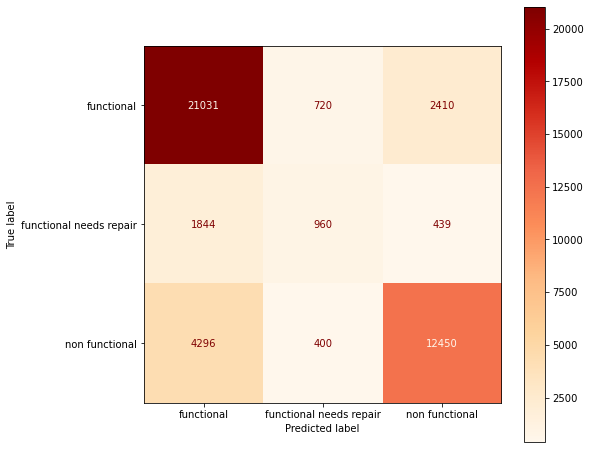

In [48]:
knn_model_pipe = Pipeline([
    ('ct',ct),
   ('knn',KNeighborsClassifier(n_jobs=Notebook_n_jobs))
])

knn_model_pipe.fit(X_train,y_train)
modelReport(knn_model_pipe,X_train,y_train)

filePath = f'models/{knn_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(knn_model_pipe, open(filePath, 'wb'))

### Hypertuned kNN

In [ ]:
params = {}
params['knn__n_neighbors'] = [5,10,15,20]
params['knn__metric']=['manhattan','euclidean']


knn_gs1 = GridSearchCV(estimator=knn_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                      verbose=2)

knn_gs1.fit(X_train,y_train)

filePath = f'models/{knn_gs1=}'.split('=')[0] + '.sav'
pickle.dump(knn_gs1, open(filePath, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
prettyPrintGridCVResults(knn_gs1)

### Hypertuned SMOTE KNN


In [ ]:
knn_imb_model_pipe = ImPipeline([
    ('sm',SMOTE(random_state=42)),
   ('knn',KNeighborsClassifier())
])

knn_imb_model_pipe.fit(X_train,y_train)
filePath = f'models/{knn_imb_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(knn_imb_model_pipe, open(filePath, 'wb'))

cross_val_score(knn_imb_model_pipe,X_train,y_train,cv=5).mean()

## XGBoost

In [21]:
ct = ColumnTransformer(transformers=[

    ('ct_cyr', subpipe_num, ['construction_year']),
    
    # Note: region is passed to allow groupby. Not returned.
    ('ct_coord', subpipe_coord, ['latitude', 'longitude', 'region']),
    
    ('ct_cat1', subpipe_cat1, ['public_meeting','scheme_management', 'permit', 'source_class']),
    
    ('ct_cat2', subpipe_cat2, ['basin', 'extraction_type_class', 'management', 'payment', 'quality_group',
                               'quantity', 'source_type', 'waterpoint_type_group']),

])

In [22]:
XGBRF_model_pipe = Pipeline([
    ('ct',ct),
   ('xg',xgboost.XGBRFClassifier(random_state=42,n_jobs=Notebook_n_jobs))
])

,Scores
,
Accuracy,0.7271
Precision,0.7241
Recall,0.5113
F1,0.5151


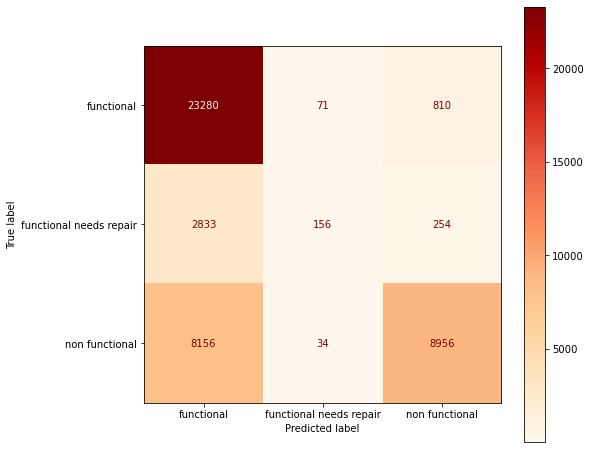

In [23]:
XGBRF_model_pipe.fit(X_train,y_train)
modelReport(XGBRF_model_pipe,X_train,y_train)

filePath = f'models/{XGBRF_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(XGBRF_model_pipe, open(filePath, 'wb'))

### Hypertuned XGBoost

#### Round 1

In [24]:
params = {}
# params['xg__learning_rate'] = [0.1,1,10]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['gini','entropy']
params['xg__n_estimators'] = [350,550]
# params['xg__max_depth'] = [20,30]
params['xg__max_leaf_nodes']=[4000,5000]


xgbrf_gs1 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

xgbrf_gs1.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs1=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs1, open(filePath, 'wb'))

[00:55:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion, max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Per the output criterion, max_leaf_nodes might not be used. Dropping them from further hypertunes

In [25]:
prettyPrintGridCVResults(xgbrf_gs1)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__max_leaf_nodes,param_xg__n_estimators
Rank (By Accuracy),,,,,,,
1,0.7264,0.7245,0.5104,0.5138,gini,4000,550
1,0.7264,0.7245,0.5104,0.5138,gini,5000,550
1,0.7264,0.7245,0.5104,0.5138,entropy,4000,550
1,0.7264,0.7245,0.5104,0.5138,entropy,5000,550
5,0.7262,0.7213,0.5104,0.5139,gini,4000,350
5,0.7262,0.7213,0.5104,0.5139,gini,5000,350
5,0.7262,0.7213,0.5104,0.5139,entropy,4000,350
5,0.7262,0.7213,0.5104,0.5139,entropy,5000,350


#### Round 2

In [36]:
params = {}
params['xg__learning_rate'] = [1,10]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
# params['xg__criterion'] = ['gini','entropy']
# params['xg__n_estimators'] = [350]
params['xg__max_depth'] = [25,30]
# params['xg__max_leaf_nodes']=[4000,5000]


xgbrf_gs2 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=2)

xgbrf_gs2.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs2=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs2, open(filePath, 'wb'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [37]:
prettyPrintGridCVResults(xgbrf_gs2)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__learning_rate,param_xg__max_depth
Rank (By Accuracy),,,,,,
1,0.7978,0.7149,0.6520,0.6729,1,25
1,0.7978,0.7149,0.6520,0.6729,10,25
3,0.7972,0.7136,0.6533,0.6736,1,30
3,0.7972,0.7136,0.6533,0.6736,10,30


#### Round 3

In [38]:
params = {}
params['xg__learning_rate'] = [0.1,1,10]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['entropy']
params['xg__n_estimators'] = [450]
params['xg__max_depth'] = [27]
params['xg__max_leaf_nodes']=[4500]


xgbrf_gs3 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=2)

xgbrf_gs3.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs3=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs3, open(filePath, 'wb'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[02:16:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion, max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [39]:
prettyPrintGridCVResults(xgbrf_gs3)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__learning_rate,param_xg__max_depth,param_xg__max_leaf_nodes,param_xg__n_estimators
Rank (By Accuracy),,,,,,,,,
1,0.7971,0.7133,0.6516,0.6721,entropy,0.1,27,4500,450
1,0.7971,0.7133,0.6516,0.6721,entropy,1,27,4500,450
1,0.7971,0.7133,0.6516,0.6721,entropy,10,27,4500,450


#### Round 4

In [40]:
params = {}
params['xg__learning_rate'] = [0.1]
# params['xg__reg_lambda'] = [1e-06,1e-05,1e-04]
params['xg__criterion'] = ['entropy','gini']
params['xg__n_estimators'] = [500,550]
params['xg__max_depth'] = [20,25]
# params['xg__max_leaf_nodes']=[4500]


xgbrf_gs4 = GridSearchCV(estimator=XGBRF_model_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True,
                        verbose=3)

xgbrf_gs4.fit(X_train,y_train)

filePath = f'models/{xgbrf_gs4=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs4, open(filePath, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[03:01:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [41]:
prettyPrintGridCVResults(xgbrf_gs4)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_xg__criterion,param_xg__learning_rate,param_xg__max_depth,param_xg__n_estimators
Rank (By Accuracy),,,,,,,,
1,0.7992,0.7243,0.6474,0.6711,entropy,0.1,20,550
1,0.7992,0.7243,0.6474,0.6711,gini,0.1,20,550
3,0.7990,0.7234,0.6469,0.6705,entropy,0.1,20,500
3,0.7990,0.7234,0.6469,0.6705,gini,0.1,20,500
5,0.7978,0.7158,0.6517,0.6729,entropy,0.1,25,550
5,0.7978,0.7158,0.6517,0.6729,gini,0.1,25,550
7,0.7976,0.7156,0.6512,0.6724,entropy,0.1,25,500
7,0.7976,0.7156,0.6512,0.6724,gini,0.1,25,500


### Final Model